# Project Code and Solution Report

## Basic Steps

As highlighted in the Work Plan, the plan for this project going forward is as follows:

1. Load the data and perform basic exploratory data analysis (*done in previous section*)
2. Perform any additional exploratory data analysis, which will include any prep work (i.e. missing data checks) as needed
3. Split the data into separate training and testing sets, which can be broken down into various model-readable components.
4. Develop models (ideally, multiple models would be used) to parse the data to predict customer behavior
5. Train, then test said models
6. Present findings and conclusions.

The target feature is that the 'EndDate' column is set to 'No' (This actually means that the customer's contract with Interconnect is still active)

The AUC-ROC score is the principal metric for all models, with passable models having a score of 0.85 and above. The model with the highest score will be recommended for Interconnect's use.

## Data Loading and Exploratory Data Analysis

### Basic Loading

In [1]:
import pandas as pd
import numpy as py
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
personal_data = pd.read_csv('/datasets/final_provider/personal.csv')
contract_data = pd.read_csv('/datasets/final_provider/contract.csv')
internet_data = pd.read_csv('/datasets/final_provider/internet.csv')
phone_data = pd.read_csv('/datasets/final_provider/phone.csv')

## Exploratory Data Analysis

### Basic EDA

#### Personal.csv dataset

In [3]:
print(personal_data.info())
print(personal_data.head())
print(personal_data.describe())
display(personal_data.sample(n=10))

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 7043 entries, 0 to 7042
,Data columns (total 5 columns):
, #   Column         Non-Null Count  Dtype 
,---  ------         --------------  ----- 
, 0   customerID     7043 non-null   object
, 1   gender         7043 non-null   object
, 2   SeniorCitizen  7043 non-null   int64 
, 3   Partner        7043 non-null   object
, 4   Dependents     7043 non-null   object
,dtypes: int64(1), object(4)
,memory usage: 275.2+ KB
,None
,   customerID  gender  SeniorCitizen Partner Dependents
,0  7590-VHVEG  Female              0     Yes         No
,1  5575-GNVDE    Male              0      No         No
,2  3668-QPYBK    Male              0      No         No
,3  7795-CFOCW    Male              0      No         No
,4  9237-HQITU  Female              0      No         No
,       SeniorCitizen
,count    7043.000000
,mean        0.162147
,std         0.368612
,min         0.000000
,25%         0.000000
,50%         0.000000
,75%         0.000000
,max  

,customerID,gender,SeniorCitizen,Partner,Dependents
1426,8752-GHJFU,Male,1,Yes,No
642,0970-ETWGE,Male,0,No,No
1577,9254-RBFON,Female,0,Yes,Yes
1317,9277-JOOMO,Female,0,No,No
1510,7898-PDWQE,Male,0,Yes,No
5828,0402-OAMEN,Female,0,Yes,Yes
1719,2081-VEYEH,Male,0,No,No
6153,6685-XSHHU,Male,0,Yes,Yes
6455,2478-EEWWM,Male,0,Yes,No
1436,9546-CQJSU,Female,0,No,No


#### Contract.csv dataset

In [4]:
print(contract_data.info())
print(contract_data.head())
print(contract_data.describe())
display(contract_data.sample(n=10))

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 7043 entries, 0 to 7042
,Data columns (total 8 columns):
, #   Column            Non-Null Count  Dtype  
,---  ------            --------------  -----  
, 0   customerID        7043 non-null   object 
, 1   BeginDate         7043 non-null   object 
, 2   EndDate           7043 non-null   object 
, 3   Type              7043 non-null   object 
, 4   PaperlessBilling  7043 non-null   object 
, 5   PaymentMethod     7043 non-null   object 
, 6   MonthlyCharges    7043 non-null   float64
, 7   TotalCharges      7043 non-null   object 
,dtypes: float64(1), object(7)
,memory usage: 440.3+ KB
,None
,   customerID   BeginDate              EndDate            Type  \
,0  7590-VHVEG  2020-01-01                   No  Month-to-month   
,1  5575-GNVDE  2017-04-01                   No        One year   
,2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
,3  7795-CFOCW  2016-05-01                   No        One year   
,4  9237-HQITU 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
511,8535-SFUTN,2015-01-01,No,Month-to-month,Yes,Electronic check,106.45,6300.15
5949,8756-RDDLT,2014-06-01,No,Month-to-month,No,Electronic check,44.95,3085.35
1905,1022-RKXDR,2016-09-01,No,One year,Yes,Mailed check,24.85,962.25
3089,5680-LQOGP,2014-06-01,No,Two year,Yes,Credit card (automatic),82.45,5646.6
2993,2239-CFOUJ,2020-01-01,No,One year,No,Mailed check,20.40,20.4
1380,1131-SUEKT,2015-01-01,No,One year,Yes,Bank transfer (automatic),98.45,6145.2
6610,9696-RMYBA,2019-09-01,No,Month-to-month,Yes,Mailed check,80.10,398.55
1731,8375-DKEBR,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,69.60,69.6
4852,7515-LODFU,2014-05-01,No,Two year,No,Credit card (automatic),20.30,1356.3
779,0322-CHQRU,2019-09-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,45.35,89.5


#### Internet.csv dataset

In [5]:
print(internet_data.info())
print(internet_data.head())
print(internet_data.describe())
display(internet_data.sample(n=10))

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 5517 entries, 0 to 5516
,Data columns (total 8 columns):
, #   Column            Non-Null Count  Dtype 
,---  ------            --------------  ----- 
, 0   customerID        5517 non-null   object
, 1   InternetService   5517 non-null   object
, 2   OnlineSecurity    5517 non-null   object
, 3   OnlineBackup      5517 non-null   object
, 4   DeviceProtection  5517 non-null   object
, 5   TechSupport       5517 non-null   object
, 6   StreamingTV       5517 non-null   object
, 7   StreamingMovies   5517 non-null   object
,dtypes: object(8)
,memory usage: 344.9+ KB
,None
,   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
,0  7590-VHVEG             DSL             No          Yes               No   
,1  5575-GNVDE             DSL            Yes           No              Yes   
,2  3668-QPYBK             DSL            Yes          Yes               No   
,3  7795-CFOCW             DSL            Yes           

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4807,0644-OQMDK,Fiber optic,No,No,No,No,No,No
5474,0218-QNVAS,Fiber optic,No,Yes,No,No,Yes,Yes
984,0384-RVBPI,DSL,Yes,No,Yes,No,No,Yes
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
2739,8295-KMENE,DSL,Yes,No,Yes,Yes,Yes,No
1094,8999-YPYBV,DSL,Yes,Yes,Yes,Yes,Yes,Yes
1791,3571-RFHAR,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
84,7123-WQUHX,Fiber optic,No,No,Yes,Yes,Yes,No
1479,4524-QCSSM,DSL,Yes,Yes,No,No,No,Yes
4025,5928-QLDHB,Fiber optic,No,No,No,No,No,No


#### Phone.csv dataset

In [6]:
print(phone_data.info())
print(phone_data.head())
print(phone_data.describe())
display(phone_data.sample(n=10))

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 6361 entries, 0 to 6360
,Data columns (total 2 columns):
, #   Column         Non-Null Count  Dtype 
,---  ------         --------------  ----- 
, 0   customerID     6361 non-null   object
, 1   MultipleLines  6361 non-null   object
,dtypes: object(2)
,memory usage: 99.5+ KB
,None
,   customerID MultipleLines
,0  5575-GNVDE            No
,1  3668-QPYBK            No
,2  9237-HQITU            No
,3  9305-CDSKC           Yes
,4  1452-KIOVK           Yes
,        customerID MultipleLines
,count         6361          6361
,unique        6361             2
,top     5850-BDWCY            No
,freq             1          3390


,customerID,MultipleLines
5617,1585-MQSSU,No
5832,0254-WWRKD,No
1868,8543-MSDMF,No
681,1410-RSCMR,No
4885,7450-NWRTR,Yes
5427,3721-CNZHX,No
3975,7691-XVTZH,Yes
2913,8550-XSXUQ,Yes
5268,1555-HAPSU,Yes
306,5924-SNGKP,No


### Advanced EDA

#### Missing Value Checks

In [7]:
print(personal_data.isnull().sum())
print(contract_data.isnull().sum())
print(internet_data.isnull().sum())
print(phone_data.isnull().sum())

customerID       0
,gender           0
,SeniorCitizen    0
,Partner          0
,Dependents       0
,dtype: int64
,customerID          0
,BeginDate           0
,EndDate             0
,Type                0
,PaperlessBilling    0
,PaymentMethod       0
,MonthlyCharges      0
,TotalCharges        0
,dtype: int64
,customerID          0
,InternetService     0
,OnlineSecurity      0
,OnlineBackup        0
,DeviceProtection    0
,TechSupport         0
,StreamingTV         0
,StreamingMovies     0
,dtype: int64
,customerID       0
,MultipleLines    0
,dtype: int64


#### Duplicate Values Check

In [8]:
print(personal_data.duplicated().sum())
print(contract_data.duplicated().sum())
print(internet_data.duplicated().sum())
print(phone_data.duplicated().sum())

0
,0
,0
,0


## Model Preparation

### Data Merging (into a single usable dataset)

In [9]:
merged_data = personal_data.merge(
    contract_data[['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']],
    on='customerID', how='right'
)

In [10]:
merged_data = merged_data.merge(
    internet_data[['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']],
    on='customerID', how='right'
)

In [11]:
merged_data = merged_data.merge(
    phone_data[['customerID', 'MultipleLines']],
    on='customerID', how='right'
)

In [12]:
merged_data = merged_data.drop('customerID', axis=1)

In [13]:
display(merged_data.sample(n=10))

,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3760,Male,0.0,No,No,2017-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,84.8,2043.45,Fiber optic,No,No,No,No,No,Yes,Yes
4549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3143,Female,0.0,No,No,2017-11-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),88.8,2274.35,Fiber optic,No,No,No,No,Yes,Yes,No
768,Male,0.0,Yes,No,2014-02-01,No,Two year,Yes,Credit card (automatic),92.0,6782.15,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5130,Female,0.0,No,No,2019-06-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,79.0,522.95,Fiber optic,No,No,No,No,Yes,No,No
5577,Female,0.0,Yes,Yes,2014-02-01,No,Two year,Yes,Bank transfer (automatic),109.2,7711.45,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
1336,Male,0.0,No,No,2014-12-01,No,One year,Yes,Bank transfer (automatic),92.3,5731.45,Fiber optic,Yes,Yes,No,No,No,Yes,Yes
2470,Female,0.0,No,No,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Mailed check,50.1,50.1,DSL,No,No,No,No,No,No,Yes
900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2702,Male,0.0,No,No,2015-08-01,2019-11-01 00:00:00,Month-to-month,No,Credit card (automatic),80.0,4242.35,Fiber optic,No,No,Yes,No,No,No,Yes


## Data Encoding and Splitting

### Target Encoding

In [14]:
merged_data['EndDate'] = merged_data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
merged_data['TotalCharges'] = pd.to_numeric(merged_data['TotalCharges'], errors='coerce')
merged_data['TotalChargs'] = merged_data['TotalCharges'].fillna(0)

### Post-Merge Cleanup

In [15]:
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

merged_data[internet_cols] = merged_data[internet_cols].fillna('No internet service')
merged_data['MultipleLines'] = merged_data['MultipleLines'].fillna('No phone service')

In [16]:
merged_data = merged_data.drop(columns=['BeginDate']).drop_duplicates()

target = merged_data['EndDate']
features = merged_data.drop(columns=['EndDate'])

### Train/Test Split

In [17]:
target = merged_data['EndDate']
features = merged_data.drop(columns=['EndDate'])

In [18]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=12345)

### Features Encoding

In [19]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
               'StreamingMovies', 'MultipleLines']

In [20]:
features_train[binary_cols] = features_train[binary_cols].replace({
    'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0,
    'No internet service': 0, 'No phone service': 0
})

features_test[binary_cols] = features_test[binary_cols].replace({
    'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0,
    'No internet service': 0, 'No phone service': 0
})

/.venv/lib/python3.9/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
,A value is trying to be set on a copy of a slice from a DataFrame.
,Try using .loc[row_indexer,col_indexer] = value instead
,
,See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
,  self[k1] = value[k2]


In [21]:
multi_cols = ['Type', 'PaymentMethod', 'InternetService']

In [22]:
features_train = pd.get_dummies(features_train, columns=multi_cols)
features_test = pd.get_dummies(features_test, columns=multi_cols)

In [23]:
features_train = features_train.dropna()
features_test = features_test.dropna()

features_train, features_test = features_train.align(features_test, join='left', axis=1, fill_value=0)

target_train = target_train.loc[features_train.index]
target_test = target_test.loc[features_test.index]

In [24]:
numeric_cols = ['MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
features_train[numeric_cols] = scaler.fit_transform(features_train[numeric_cols])
features_test[numeric_cols] = scaler.transform(features_test[numeric_cols])

## Model Creation and Testing

Overall, at least **seven** models will be used to determine the best model to be used:

- Logistic Regression
- Random Forest
- Decision Tree
- SVR Regression
- K-Nearest Neighbors
- XGradient Boosting
- LightGBM

### Model 1: Logistic Regression

AUC-ROC score: 0.8097433290978399


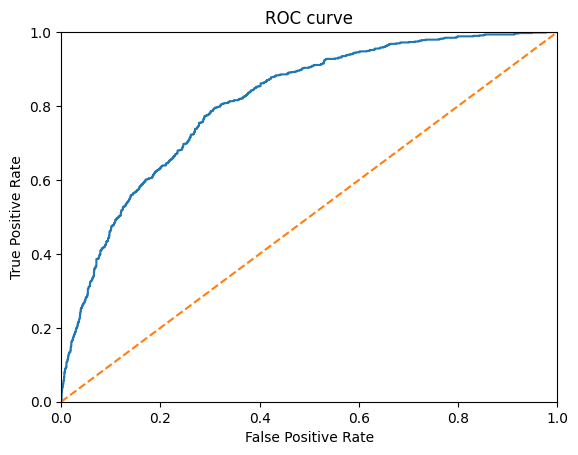

In [25]:
log_model = LogisticRegression(random_state=12345, solver='liblinear')
log_model.fit(features_train, target_train)

probabilities_test1 = log_model.predict_proba(features_test)
probabilities_one_test1 = probabilities_test1[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test1)

auc_roc = roc_auc_score(target_test, probabilities_one_test1)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Model 2: Random Forest

#### Random Forest Regressor

AUC-ROC score: 0.8081653797282768


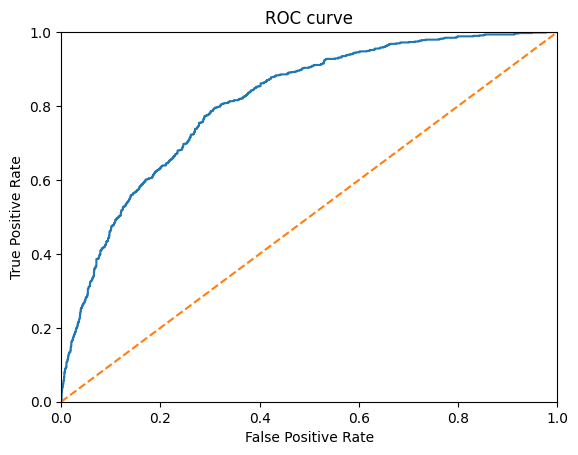

In [26]:
rf_param_grid1 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20, 50]
}

rf_model1 = RandomForestRegressor(random_state=42)

random_search_rf1 = RandomizedSearchCV(
    estimator=rf_model1,
    param_distributions=rf_param_grid1,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)
random_search_rf1.fit(features_train, target_train)

best_rf1 = random_search_rf1.best_estimator_

rf_predictions1 = best_rf1.predict(features_test)

auc_roc = roc_auc_score(target_test, rf_predictions1)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

#### Random Forest Classifier

AUC-ROC score: 0.7410747727494869


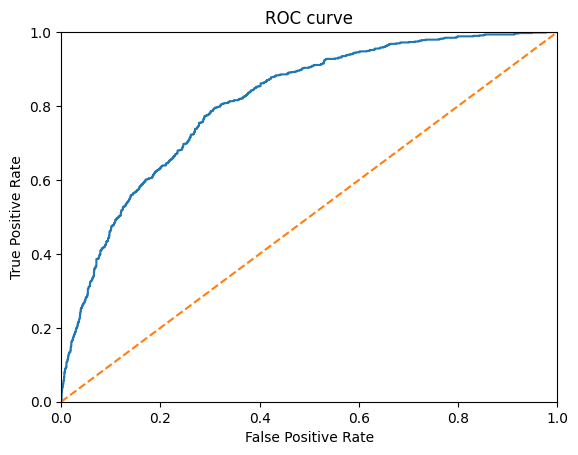

In [27]:
rf_param_grid2 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20, 50],
    'class_weight': [None, 'balanced']
}

rf_model2 = RandomForestClassifier(random_state=42)

random_search_rf2 = RandomizedSearchCV(
    estimator=rf_model2,
    param_distributions=rf_param_grid2,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc'
)
random_search_rf2.fit(features_train, target_train)

best_rf2 = random_search_rf2.best_estimator_

rf_predictions2 = best_rf2.predict(features_test)

auc_roc = roc_auc_score(target_test, rf_predictions2)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Model 3: Decision Tree

#### Decision Tree Regressor

AUC-ROC score: 0.6832035969113478


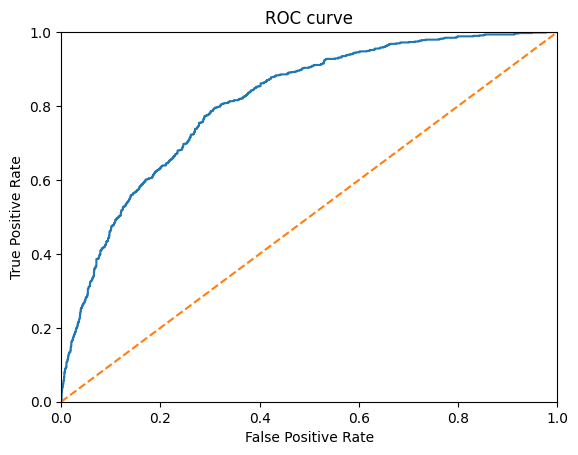

In [28]:
dt_param_grid1 = {
    'max_depth': [50, 100, 200],
    'min_samples_split': [5, 10, 20, 50]
}

dt_model1 = DecisionTreeClassifier()

random_search_dt1 = RandomizedSearchCV(
    estimator=dt_model1,
    param_distributions=dt_param_grid1,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search_dt1.fit(features_train, target_train)

best_dt1 = random_search_dt1.best_estimator_

dt_predictions1 = best_dt1.predict(features_test)

auc_roc = roc_auc_score(target_test, dt_predictions1)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

#### Decision Tree Classifier

AUC-ROC score: 0.7118326654285994


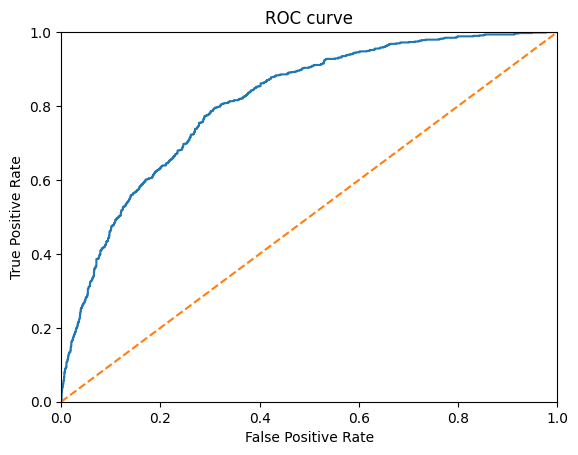

In [29]:
dt_param_grid2 = {
    'max_depth': [None, 50, 100, 200],
    'min_samples_split': [None, 5, 10, 20, 50],
    'class_weight': [None, 'balanced']
}

dt_model2 = DecisionTreeClassifier()

random_search_dt2 = RandomizedSearchCV(
    estimator=dt_model2,
    param_distributions=dt_param_grid2,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search_dt2.fit(features_train, target_train)

best_dt2 = random_search_dt2.best_estimator_

dt_predictions2 = best_dt2.predict(features_test)

auc_roc = roc_auc_score(target_test, dt_predictions2)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Model 4: Gradient Boosting

AUC-ROC score: 0.8036926986609324


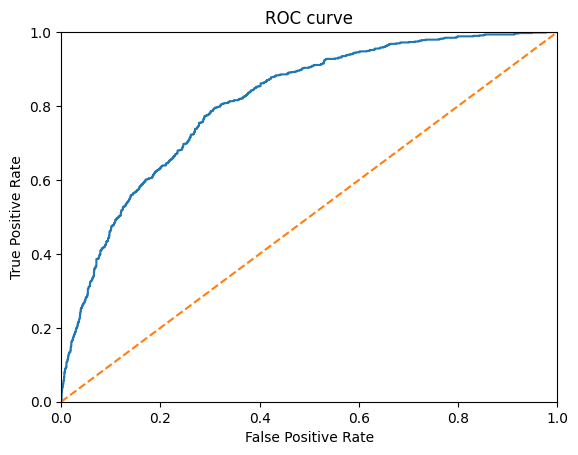

In [30]:
gb_param_grid1 = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.1, 1, 10],
    'max_depth': [3, 5]
}

gb_model1 = GradientBoostingRegressor()

random_search_gb1 = RandomizedSearchCV(
    estimator=gb_model1,
    param_distributions=gb_param_grid1,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search_gb1.fit(features_train, target_train)

best_gb1 = random_search_gb1.best_estimator_

gb_predictions1 = best_gb1.predict(features_test)

auc_roc = roc_auc_score(target_test, gb_predictions1)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Model 5: K-Nearest Neighbors

/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
,  warnings.warn(


AUC-ROC score: 0.6909314827485094


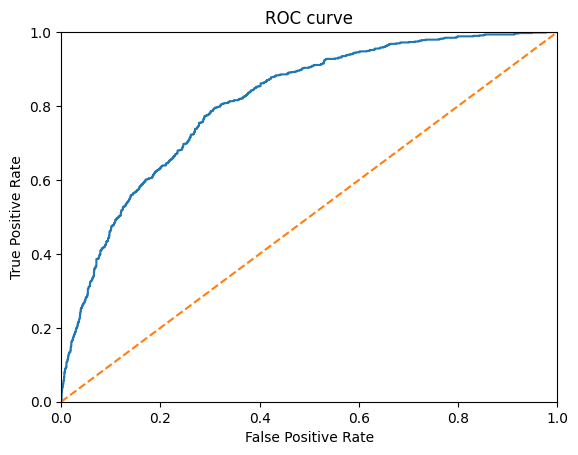

In [31]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],
}

knn_model = KNeighborsRegressor()

random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=knn_param_grid,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search_knn.fit(features_train, target_train)

best_knn = random_search_knn.best_estimator_

knn_predictions = best_knn.predict(features_test)

auc_roc = roc_auc_score(target_test, knn_predictions)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Model 6: XGBoost

AUC-ROC score: 0.8128327631707555


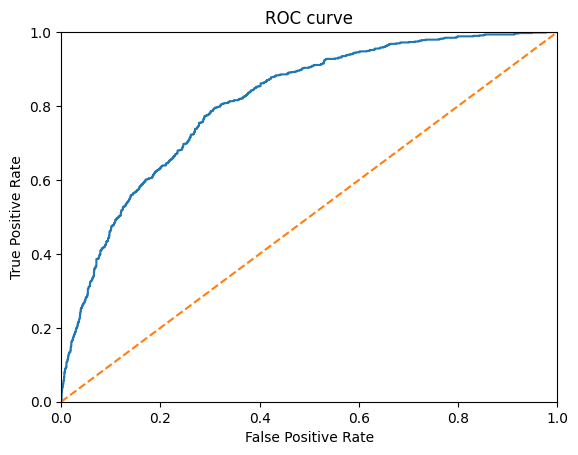

In [32]:
xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
}

xgb_model = XGBRegressor()

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search_xgb.fit(
    features_train, target_train,
    eval_set=[(features_train, target_train)],
    eval_metric='rmse',
    early_stopping_rounds=10,
    verbose=False
)

best_xgb = random_search_xgb.best_estimator_

xgb_predictions = best_xgb.predict(features_test)

auc_roc = roc_auc_score(target_test, xgb_predictions)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

### Model 7: LightGBM

/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
,  warnings.warn(
,/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
,  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
,/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
,  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
,/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'earl

AUC-ROC score: 0.8128327631707555


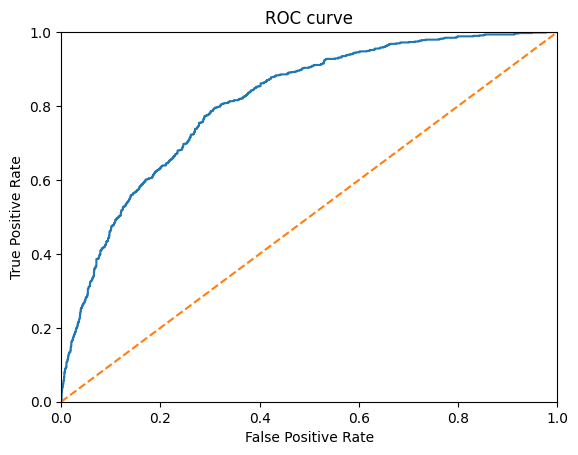

In [33]:
lgb_param_grid = {
    'n_estimators': [50, 100],
    #'num_leaves': [31, 40, 50],
    'learning_rate': [0.1, 0.3],
    #'boosting_type': ['gbdt', 'dart'],
}

lgbm_model = lgb.LGBMRegressor()

random_search_lgb = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgb_param_grid,
    n_iter=5,
    cv=2,
    n_jobs=-1,
    scoring='roc_auc'
)

random_search_lgb.fit(
    features_train, target_train,
    eval_set=[(features_train, target_train)],
    eval_metric='rmse',
    early_stopping_rounds=10,
    verbose=False
)

best_lgb = random_search_lgb.best_estimator_

lgbm_predictions = best_xgb.predict(features_test)

auc_roc = roc_auc_score(target_test, lgbm_predictions)
print(f"AUC-ROC score: {auc_roc}")

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

## Conclusions

Nine models were created, which utilized the training data to train the data before making predictions using the test data. Often the data itself was encoded as much as possible to prevent data leaks and help improve the AUC-ROC score, which initial results proved somewhat disappointing.

Four models (K-Nearest Neighbors, Decision Tree (both Regressor and Classifier), and Random Forest Classifier) failed to meet the minimum passable threshhold, and of the five that did, they all failed to have an AUC-ROC score of at least 0.85. Among those five, both XGBoost and LightGBM showed the highest returns, with both AUC-ROC scores at around 0.813, with comparable runtimes to boot.

Given this, it is highly recommended that InterConnect use either XGBoost and LightGBM for its models.

# Checklist

- [x] Data is fully loaded
- [x] Exploratory Data Analysis has been conducted
- [x] Datasets are fully merged
- [x] Training and Testing Data are Split
- [x] Models are created and trained
- [x] Models are tested
- [x] Conclusions have been provided
- [x] Code is orderly and error-free